In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import natsort
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
warnings.filterwarnings('ignore')

In [2]:
# Define constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH*3

In [4]:
di1 = "../graduation_dataset/race2/test/"

filenames = os.listdir(di1)

categories = []

for filename in filenames:
    category1 = filename.split('_')[0]
    category2 = filename.split('_')[1]
    category = category1 + "_" + category2
    if category == 'asian_noglasses':
        categories.append(0)
    elif category == 'asian_glasses' :
        categories.append(1)
    elif category == 'black_noglasses' :
        categories.append(2)
    elif category == 'black_glasses' :
        categories.append(3)
    elif category == 'white_noglasses' :
        categories.append(4)
    elif category == 'white_glasses' :
        categories.append(5)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,asian_glasses_000.png,1
1,asian_glasses_001.png,1
2,asian_glasses_002.png,1
3,asian_glasses_003.png,1
4,asian_glasses_004.png,1


In [5]:
df.tail()

,filename,category
628,white_noglasses_098.png,4
629,white_noglasses_099.png,4
630,white_noglasses_100.png,4
631,white_noglasses_101.png,4
632,white_noglasses_102.png,4


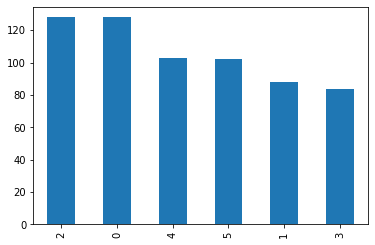

In [6]:
df['category'].value_counts().plot.bar()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu',input_shape = (128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)      

In [115]:
df["category"] = df["category"].replace({0: 'asian_noglasses', 1: 'asian_glasses', 
                                         2:'black_noglasses', 3: 'black_glasses', 4:'white_noglasses', 
                                        5:'white_glasses' })

In [116]:
df.head()

,filename,category
0,asian_glasses_000.png,asian_glasses
1,asian_glasses_001.png,asian_glasses
2,asian_glasses_002.png,asian_glasses
3,asian_glasses_003.png,asian_glasses
4,asian_glasses_004.png,asian_glasses


In [117]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

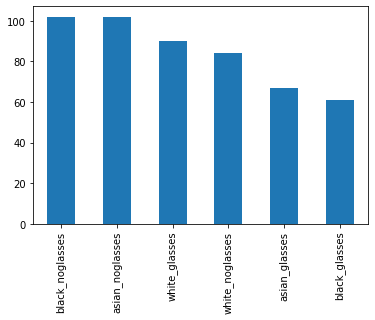

In [118]:
train_df['category'].value_counts().plot.bar()

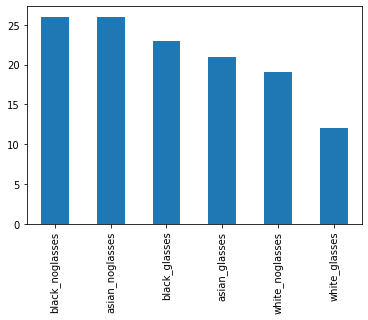

In [119]:
validate_df['category'].value_counts().plot.bar()

In [120]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=30

In [121]:
#Train Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
     train_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)

Found 506 validated image filenames belonging to 6 classes.


In [122]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)


Found 127 validated image filenames belonging to 6 classes.


In [123]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


In [124]:
# Fit model
epochs = 3 if FAST_RUN else 100

history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps= total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/100
16/16 [==============================] - 20s 1s/step - loss: 2.2005 - accuracy: 0.1954 - val_loss: 1.7876 - val_accuracy: 0.1333
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 1.7554 - accuracy: 0.1979 - val_loss: 1.7848 - val_accuracy: 0.2333
Epoch 3/100
16/16 [==============================] - 20s 1s/step - loss: 1.7462 - accuracy: 0.2269 - val_loss: 1.7845 - val_accuracy: 0.3500
Epoch 4/100
16/16 [==============================] - 23s 1s/step - loss: 1.7224 - accuracy: 0.2353 - val_loss: 1.7772 - val_accuracy: 0.3167
Epoch 5/100
16/16 [==============================] - 25s 2s/step - loss: 1.7176 - accuracy: 0.2521 - val_loss: 1.7690 - val_accuracy: 0.3750
Epoch 6/100
16/16 [==============================] - 25s 2s/step - loss: 1.6622 - accuracy: 0.3130 - val_loss: 1.7503 - val_accuracy: 0.4500
Epoch 7/100
16/16 [==============================] - 20s 1s/step - loss: 1.6164 - accuracy: 0.3172 - val_loss: 1.7334 - val_accuracy: 0.3583
Epoch 8/100
1

Epoch 59/100
16/16 [==============================] - 11s 712ms/step - loss: 1.0239 - accuracy: 0.5609 - val_loss: 1.2575 - val_accuracy: 0.5333
Epoch 60/100
16/16 [==============================] - 12s 749ms/step - loss: 1.0641 - accuracy: 0.5567 - val_loss: 1.2663 - val_accuracy: 0.5083
Epoch 61/100
16/16 [==============================] - 13s 825ms/step - loss: 1.0675 - accuracy: 0.5462 - val_loss: 1.3030 - val_accuracy: 0.4750
Epoch 62/100
16/16 [==============================] - 23s 1s/step - loss: 1.0149 - accuracy: 0.5840 - val_loss: 1.2688 - val_accuracy: 0.5667
Epoch 63/100
16/16 [==============================] - 27s 2s/step - loss: 1.0244 - accuracy: 0.5777 - val_loss: 1.2482 - val_accuracy: 0.5583
Epoch 64/100
16/16 [==============================] - 22s 1s/step - loss: 1.0163 - accuracy: 0.6050 - val_loss: 1.2719 - val_accuracy: 0.4750
Epoch 65/100
16/16 [==============================] - 20s 1s/step - loss: 1.0385 - accuracy: 0.5924 - val_loss: 1.2820 - val_accuracy: 0.48

In [125]:
model.save_weights("skin_model_batch_1_epoch_50_adagrad.h5")

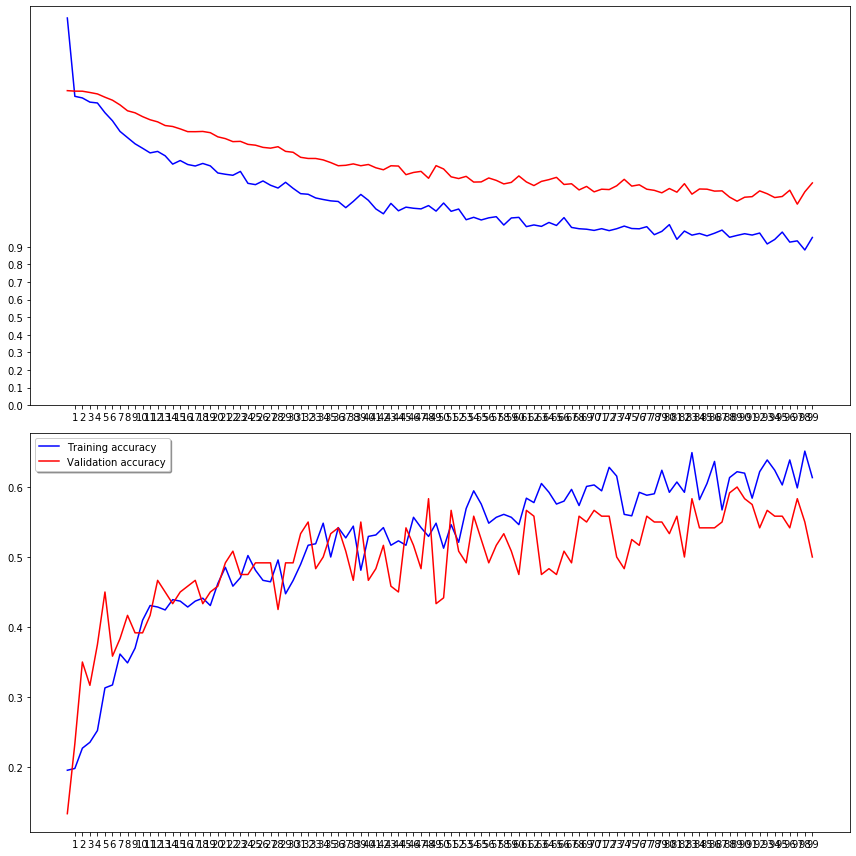

In [126]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [24]:
from PIL import Image
import numpy as np
from skimage import transform
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import cv2

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
file_path = '../graduation_dataset/race_test/'
filenames = os.listdir(file_path)
for filename in filenames:
    filepath = ''
    filepath = file_path + filename
    image = load(filepath)
    
    
    result = model.predict(image)
    
    result[0][0] = int(result[0][0]*10000)
    result[0][1] = int(result[0][1]*10000)
    result[0][2] = int(result[0][2]*10000) 
    
    print(filename)
    print('예측: ')
    if max(result[0]) == result[0][0]:
        print('asian')
    elif max(result[0]) == result[0][1]:
        print('black')
    else:
        print('white')
    print(result[0])
    print('#############################')


asian_000.png
예측: 
black
[  33. 1025.    5.]
#############################
asian_001.png
예측: 
black
[ 52. 223.  12.]
#############################
asian_002.jpg
예측: 
asian
[3334.  371.   83.]
#############################
asian_007.png
예측: 
black
[   0. 7045.    0.]
#############################
asian_008.png
예측: 
black
[   0. 5537.    0.]
#############################
asian_009.png
예측: 
black
[2.000e+00 5.061e+03 0.000e+00]
#############################
asian_022.png
예측: 
black
[   0. 4409.    0.]
#############################
asian_023.png
예측: 
black
[ 21. 688.  13.]
#############################
asian_024.png
예측: 
black
[202. 357.  68.]
#############################
asian_028.png
예측: 
black
[   5. 1594.    2.]
#############################
black_023.png
예측: 
black
[1.000e+00 3.846e+03 1.000e+00]
#############################
black_024.png
예측: 
black
[1.000e+00 2.671e+03 1.000e+00]
#############################
black_025.png
예측: 
black
[   0. 3793.    0.]
############################